In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')


if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sn.config.seed = 42



本次實驗目標為模擬基本的通訊架構，如下圖

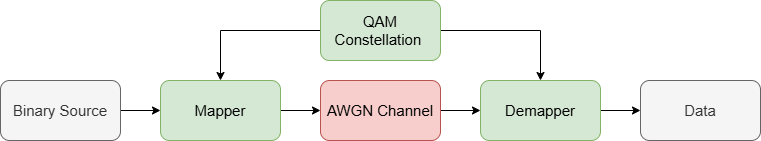

在基礎教學中將學習如何使用Sionna建立一個簡單的End-to-end通訊系統。從二進位的原始資料到訊號的Modulation、Channel、Demodulation，最後還原出二進位原始資料並計算其Bit error rate(BER)

In [2]:
#生成binary source
binary_source = sn.utils.BinarySource()

batch_size=10
data_length=1024
data_bits = binary_source([batch_size, data_length])
print("Shape of data bits: ", data_bits.shape)
print("Raw data:")
print(data_bits)

Shape of data bits:  (10, 1024)
Raw data:
tf.Tensor(
[[1. 1. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 1. 0. 1.]
 ...
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]], shape=(10, 1024), dtype=float32)


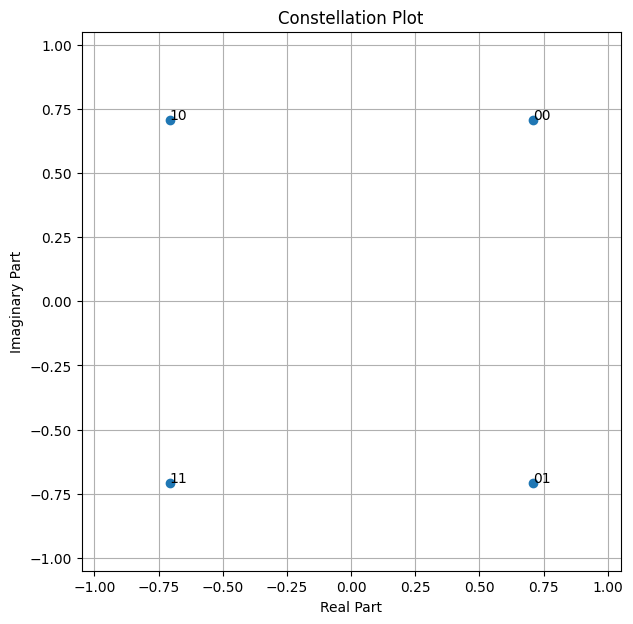

In [3]:
#生成mapper和demapper (modulation/demodulation) 
num_bits_per_symbol = 2 # QPSK
constellation = sn.mapping.Constellation("qam", num_bits_per_symbol)
constellation.show();

mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper("app", constellation=constellation)

In [4]:
#生成AWGN channel
awgn_channel = sn.channel.AWGN()

#生成noise
SNR_db=10
no = sn.utils.ebnodb2no(ebno_db=SNR_db,
                        num_bits_per_symbol=num_bits_per_symbol,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

In [5]:
#完整模擬流程
batch_size=10
data_length=1024
print("generate data ...")
data_bits = binary_source([batch_size, data_length])
print("Shape of data: ", data_bits.shape)

x = mapper(data_bits)
print("Shape of x: ", x.shape)

y = awgn_channel([x, no])
print("Shape of y: ", y.shape)

llr = demapper([y, no])
print("Shape of llr: ", llr.shape)

# 將llr轉換為bits (0 或 1)
data_bits_received = sn.utils.hard_decisions(llr)
print("Shape of received data", data_bits_received.shape)

ber=sn.utils.compute_ber(data_bits, data_bits_received)
print(f"BER: {ber}" )

generate data ...
Shape of data:  (10, 1024)
Shape of x:  (10, 512)
Shape of y:  (10, 512)
Shape of llr:  (10, 1024)
Shape of received data (10, 1024)
BER: 0.0


In [6]:
#各個參數的詳細資訊
import numpy as np
num_samples = 8 # how many samples shall be printed
num_symbols = int(num_samples/num_bits_per_symbol)

print(f"First {num_samples} transmitted bits: {data_bits[0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(llr[0,:num_samples], 2)}")
print(f"First {num_samples} demapped received data: {np.round(data_bits_received[0,:num_samples], 2)}")


First 8 transmitted bits: [1. 1. 0. 1. 1. 0. 1. 1.]
First 4 transmitted symbols: [-0.71-0.71j  0.71-0.71j -0.71+0.71j -0.71-0.71j]
First 4 received symbols: [-0.75-1.01j  0.71-0.26j -0.66+0.63j -0.98-0.58j]
First 8 demapped llrs: [ 42.29  57.27 -39.99  14.45  37.49 -35.65  55.52  32.62]
First 8 demapped received data: [1. 1. 0. 1. 1. 0. 1. 1.]


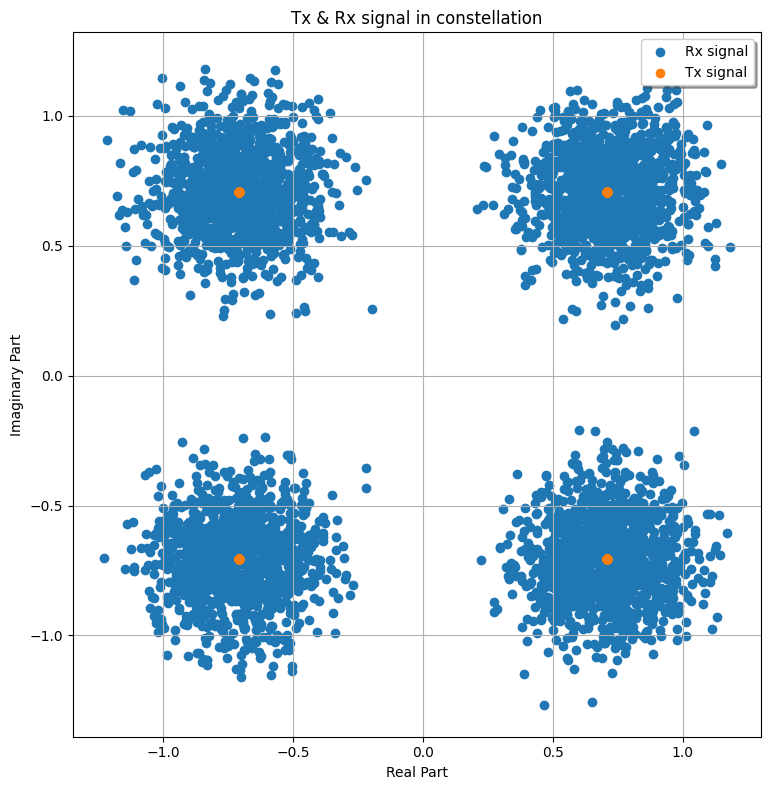

In [7]:
#圖像化收到的訊號(訊號經過Channel後的輸出)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Tx & Rx signal in constellation')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y), tf.math.imag(y), label="Rx signal")
plt.scatter(tf.math.real(x), tf.math.imag(x), label="Tx signal")
plt.legend(loc='upper right', shadow=True) 
plt.tight_layout()